# Medical Appointment No Shows

Based on the [kaggle dataset](https://www.kaggle.com/joniarroba/noshowappointments/notebooks). Reference to Joni Hoppen and Aquarela Advanced Analytics Aquarela. 

**Task**: 

Using techniques and technology of your preference:
1. Build a predictive model in either R or python that leverages the above
dataset (and any other data you would like to use) to predict missed
appointments.
2. Identify the appropriate method to evaluate your model, and provide
statistics to demonstrate performance.
3. Prepare a document to explain the findings of your model to a business
stakeholder who may or may not have technical experience. A dashboard,
short slideshow (max 5 slides) or short document (max 2 pages) would all be
acceptable.
4. Submit the code

## Understanding the Dataset and the question
### Data load and wrangling


Let's start with importing the data, transforming it into a dataframe, and displaying the header:

In [824]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn import metrics

In [825]:
df = pd.read_csv("KaggleV2-May-2016.csv")

In [826]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


Let's check the dataset info: 

In [827]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


This looks like a very clean dataset. Let's look at the allocation b/w classes as well: 

In [828]:
# Allocation between classes
target_counts = df["No-show"].value_counts() 
target_counts

No     88208
Yes    22319
Name: No-show, dtype: int64

This is a dataset which is balanced enough. However, we should be careful using metrics like `accuracy` as they would not be representative of the performance. Now, let's clean up the column names and handle data types. We can also drop some of the columns if they are not required. 

Firstly, we don't need PatientId and AppointmentID because these are just ids specific to patient and appointment and there is no use in including these into analysis. 

In [829]:
df.drop(['PatientId', 'AppointmentID'], axis=1, inplace=True)

Let's rename the columns using camelCase and correcting misprints: 

In [830]:
df.columns = ['gender', 
              'scheduledDay', 
              'appointmentDay', 
              'age', 
              'neighbourhood', 
              'scholarship', 
              'hypertension', 
              'diabetes', 
              'alcoholism', 
              'handicap', 
              'smsReceived', 
              'noShow'
             ]

`scheduledDay` and `appointmentDay` should be converted to datetime. They will be then used to derive extra features, then the dates should be deleted from the set. 

In [831]:
df['scheduledDay'] = pd.to_datetime(df['scheduledDay']).apply(lambda t: t.replace(tzinfo=None))
df['appointmentDay'] = pd.to_datetime(df['appointmentDay']).apply(lambda t: t.replace(tzinfo=None))

In [832]:
df.head()

,gender,scheduledDay,appointmentDay,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,smsReceived,noShow
0,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No


Unlike `scheduledDay`, there is no hour specified in the `appointmentDay`. We can separate hour and day for convenience.  

In [833]:
df['scheduledHour'] = df['scheduledDay'].dt.hour 
df['scheduledDay'] = df['scheduledDay'].dt.date

### Data exploration and outliers investigation

Let's check what unique values we have in the data (this would make sense to do for all the columns except for dates): 

In [834]:
colnames = df.columns.tolist() 
colnames_no_dates = [x for x in colnames if x not in ['scheduledDay', 'appointmentDay']] 

In [835]:
for featurename in colnames_no_dates: 
    print(f"\nValues for {featurename}")
    values = df[featurename].unique()
    values.sort()
    for elem in values: 
        print(elem)


Values for gender
F
M

Values for age
-1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
102
115

Values for neighbourhood
AEROPORTO
ANDORINHAS
ANTÔNIO HONÓRIO
ARIOVALDO FAVALESSA
BARRO VERMELHO
BELA VISTA
BENTO FERREIRA
BOA VISTA
BONFIM
CARATOÍRA
CENTRO
COMDUSA
CONQUISTA
CONSOLAÇÃO
CRUZAMENTO
DA PENHA
DE LOURDES
DO CABRAL
DO MOSCOSO
DO QUADRO
ENSEADA DO SUÁ
ESTRELINHA
FONTE GRANDE
FORTE SÃO JOÃO
FRADINHOS
GOIABEIRAS
GRANDE VITÓRIA
GURIGICA
HORTO
ILHA DAS CAIEIRAS
ILHA DE SANTA MARIA
ILHA DO BOI
ILHA DO FRADE
ILHA DO PRÍNCIPE
ILHAS OCEÂNICAS DE TRINDADE
INHANGUETÁ
ITARARÉ
JABOUR
JARDIM CAMBURI
JARDIM DA PENHA
JESUS DE NAZARETH
JOANA D´ARC
JUCUTUQUARA
MARIA ORTIZ
MARUÍPE
MATA DA PRAIA
MONTE BELO
MORADA DE CAMBURI
MÁRIO CYPRESTE
NAZARETH
NOVA PA

### Dates

Even though we will not use dates in modelling, it is good to understand how much data is available. 

In [836]:
print("Scheduled date range:", df.scheduledDay.min(), "to", df.scheduledDay.max())
print("Appointment date range:", df.appointmentDay.min(), "to", df.appointmentDay.max())

Scheduled date range: 2015-11-10 to 2016-06-08
Appointment date range: 2016-04-29 00:00:00 to 2016-06-08 00:00:00


**Note** that the appointment dates range **covers only around a month worth of data** which is pretty small. I would doubt that a model would perform well and would be looking for ways to enrich the data first. 

### Gender

There are just two values in this field so the dataset looks clean. Let's check the distribution of values and the relation to show/noShow target. 

In [837]:
print(df['gender'].value_counts())

F    71840
M    38687
Name: gender, dtype: int64


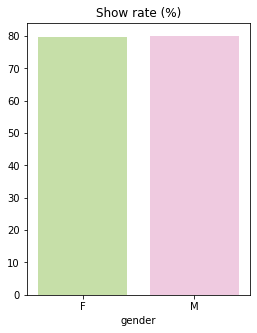

In [838]:
def rates_per_feature(feature_name, palette="PiYG_r", title="Show rate (%)", 
                      figsize=(4,5), custom_tick_interval=None): 
    plt.figure(figsize=figsize)
    df_show_rate = 100*df[df.noShow == 'No'].groupby([feature_name]).size()/df.groupby([feature_name]).size()
    fig = sns.barplot(x=df_show_rate.index, y=df_show_rate, palette=palette)
    fig.set_title(title)  
    if custom_tick_interval is not None: 
        fig.xaxis.set_major_locator(ticker.MultipleLocator(custom_tick_interval))
        fig.xaxis.set_major_formatter(ticker.ScalarFormatter())
    plt.show()
    
rates_per_feature('gender')

The show rate is practically identical. 

#### Age

Let's see how many people are there with the negative age

In [839]:
len(df[df.age == -1])

1

Just one record - we can delete it. 

In [840]:
df = df[df.age >= 0]

Now let's look at the age of 0. These could be toddler as the age is integer. Let's see if there are any people with the age of 0 and diabetes / alcoholism. Since these are diseases relevant for an older age, there should be none. 

In [841]:
len(
    df[(df['age'] == 0) & ((df['diabetes'] == 1) | (df['alcoholism'] == 1))]
)

0

There are indeed no people like this so the assumption holds true. Let's see what the distribution looks like. 

Text(0.5, 1.0, 'Age distribution')

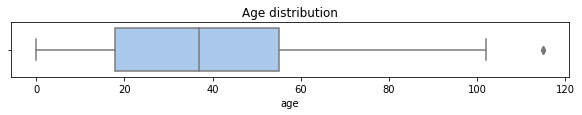

In [842]:
plt.figure(figsize=(10,1))
fig = sns.boxplot(x=df.age, palette="pastel")
fig.set_title("Age distribution")

Let's remove the outlier (> 102 years of age) too

In [843]:
df = df[df.age <= 102]

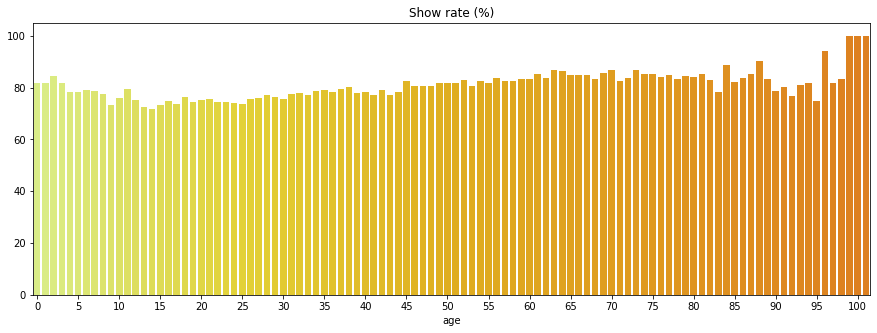

In [844]:
rates_per_feature('age', figsize=(15,5), palette='Wistia', custom_tick_interval=5)

There seems to be a difference in show rates among various ages. 

#### Neighbourhood

Let's see how the split on the neighbourhoods looks like and whether it would make sense to group smaller neighbourhoods into 'other'. The largest ones would probably correspond to a metro area. 

In [845]:
quantile = df['neighbourhood'].value_counts().quantile(0.25)

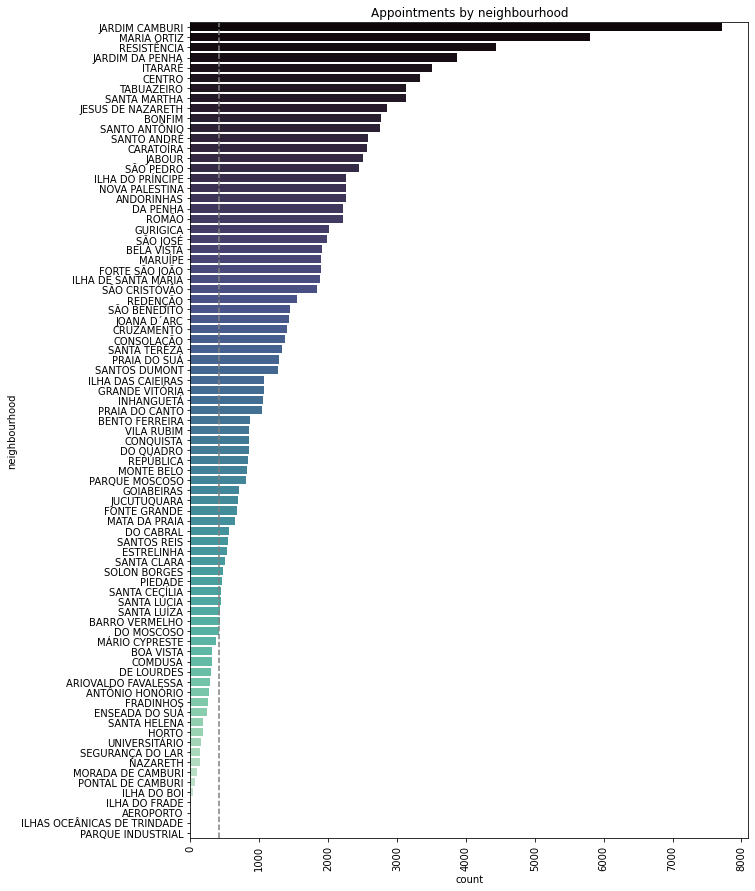

In [846]:
plt.figure(figsize=(10,15))
plt.xticks(rotation=90)
ax = sns.countplot(
    y=df.neighbourhood, 
    order=df['neighbourhood'].value_counts().index, 
    palette="mako"
) 
ax.set_title("Appointments by neighbourhood")
plt.axvline(quantile, linestyle='--', color="grey")
plt.show()

By looking at the names, the places do not actually look like they are remote. It would be easier to see this on a map but I skipped this due to time constraints. 

#### Scholarship, Hypertension, Diabetes, Alcoholism

Let's see what's the proportion of people with values in these columns and whether we should question this data. 

In [847]:
for colname in ["scholarship", "hypertension", "diabetes", "alcoholism"]: 
    print(f"Values for {colname}")
    print(df[colname].value_counts())
    print()

Values for scholarship
0    99660
1    10861
Name: scholarship, dtype: int64

Values for hypertension
0    88721
1    21800
Name: hypertension, dtype: int64

Values for diabetes
0    102578
1      7943
Name: diabetes, dtype: int64

Values for alcoholism
0    107161
1      3360
Name: alcoholism, dtype: int64



These numbers look fine and make sense. Looking at the rates: 

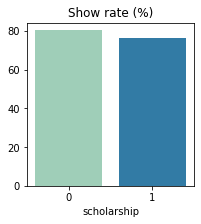

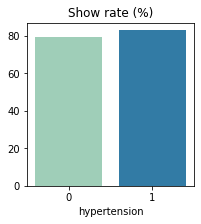

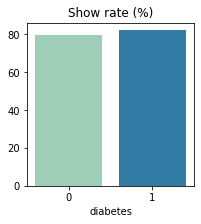

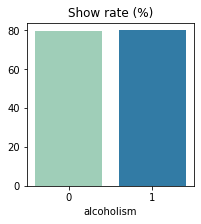

In [848]:
for colname in ["scholarship", "hypertension", "diabetes", "alcoholism"]: 
    rates_per_feature(colname, figsize=(3,3), palette='YlGnBu')

Scholarship look like the most important of all. 

#### Handicap

There are different handicap levels (1-4) as we saw above. Let's see what the split looks like. 

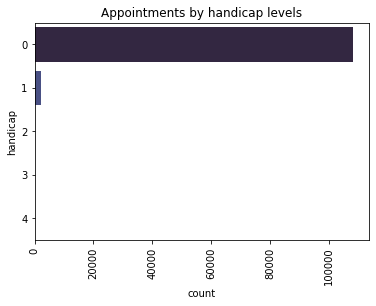

In [849]:
plt.xticks(rotation=90)
fig=sns.countplot(
    y=df.handicap,  
    palette="mako"
) 
fig.set_title("Appointments by handicap levels") 
plt.show()

In [850]:
df["handicap"].value_counts()

0    108284
1      2038
2       183
3        13
4         3
Name: handicap, dtype: int64

The absolute majority of appointments were booked by people who are not handicap (which also makes perfect sense). 

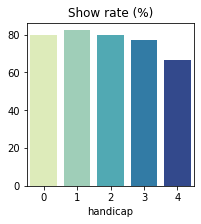

In [851]:
rates_per_feature("handicap", figsize=(3,3), palette='YlGnBu')

Show rates are worst for level 4 handicap customers.

#### SMS received

In [852]:
df["smsReceived"].value_counts()

0    75040
1    35481
Name: smsReceived, dtype: int64

It is interesting to see that most people do not get an SMS about the appointment. I would anticipate that the show rate for them is lower than for patients who got a reminder. 

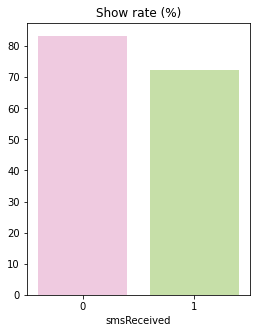

In [853]:
rates_per_feature("smsReceived", palette='PiYG')

The result is counterintuitive - people receiving SMS actually miss their appointments more often. Still, this difference looks significant so we would expect this feature to be quite important when we get to building the model. 

#### Scheduled Hour

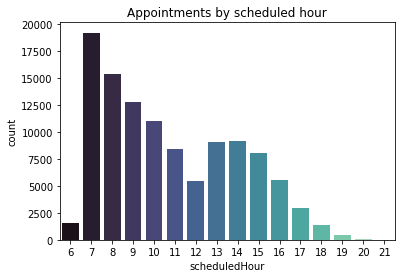

In [854]:
fig=sns.countplot(
    x=df.scheduledHour,  
    palette="mako"
) 
fig.set_title("Appointments by scheduled hour") 
plt.show()

Most people book their appointment in the morning, less during lunchtime, and even less so in the evening. This, again, makes sense. 

#### Scheduled day and appointment day

Let's see if the data is fine with regard to the scheduled / appointment day. As stated in the definition on the kaggle page: 
> The day someone called or registered the appointment, this is before appointment of course

In [855]:
df['timeToAppointment'] = df['appointmentDay'].dt.date - df['scheduledDay']
df['timeToAppointment'] = df['timeToAppointment'].dt.days

In [856]:
len(df[df['timeToAppointment'] < 0])

5

There are just 5 records where time to appointment is negative - we will consider these as errors and will drop them. 

In [857]:
df = df[df['timeToAppointment'] >= 0]

It may be helpful to add days of the week to the dataset as extra features. This would be helpful for the day of the appointment at least. 

In [858]:
df.loc[:, 'appointmentDayName'] = df['appointmentDay'].dt.day_name()

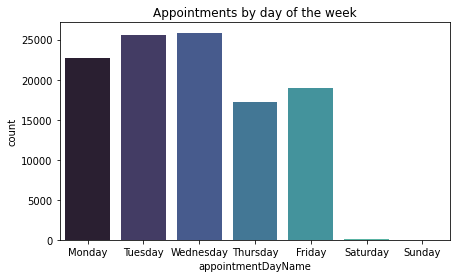

In [859]:
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
plt.figure(figsize=(7,4))
fig=sns.countplot(
    x=df.appointmentDayName,  
    order=days, 
    palette="mako"
) 
fig.set_title("Appointments by day of the week") 
plt.show() 

Most of the appointments happen during the first half of the week (Mon to Wed). 

### Dataset preparation and feature engineering

Let's look at the header again

In [860]:
df.head()

,gender,scheduledDay,appointmentDay,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,smsReceived,noShow,scheduledHour,timeToAppointment,appointmentDayName
0,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,18,0,Friday
1,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,16,0,Friday
2,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,16,0,Friday
3,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,17,0,Friday
4,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No,16,0,Friday


As discussed previously, we will drop the scheduled day and appointment day from the dataset. 

In [861]:
df.drop(['scheduledDay', 'appointmentDay'], axis=1, inplace=True)

We may also need to [one-hot-encode](https://en.wikipedia.org/wiki/One-hot) categorical variables. This is not an issue for gender (having just 2 values) and for day of the week (just 7 values), but will blow up a number of variables for the neighbourhood and for the scheduled hour. Let's see how to handle this. 

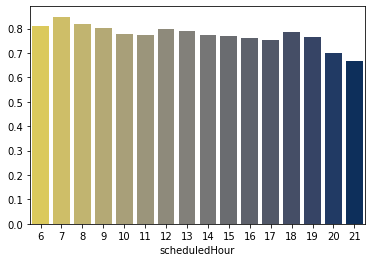

In [862]:
df_ratios = df[df.noShow == 'No'].groupby(['scheduledHour']).size()/df.groupby(['scheduledHour']).size()
fig = sns.barplot(x=df_ratios.index, y=df_ratios, palette="cividis_r") 
plt.show()

There is quite some difference in the rate depending on the hour, so it would make sense to keep this feature. Let's see the similar chart for neighbourhoods. 

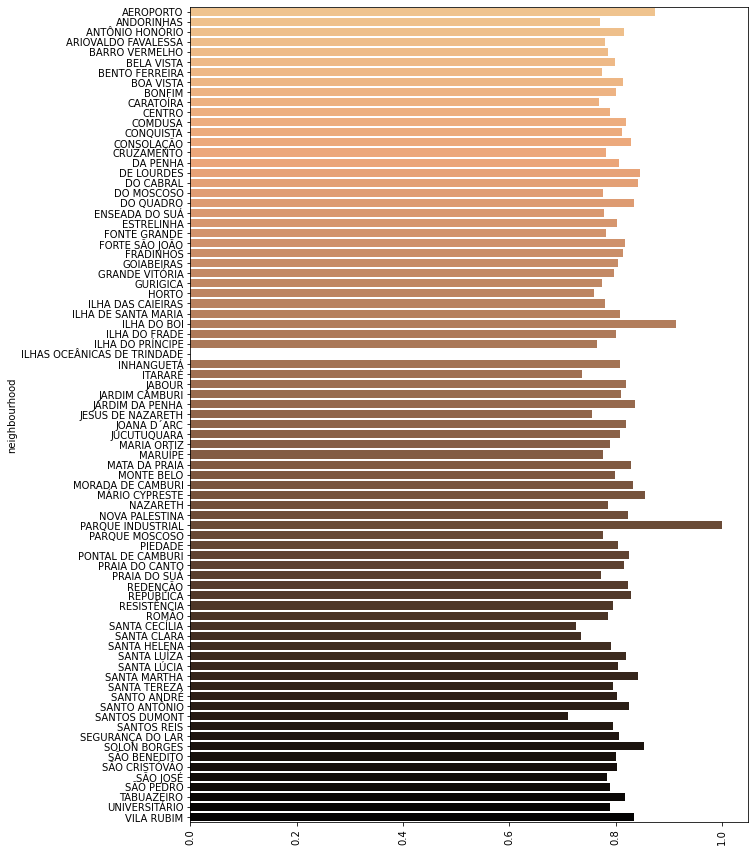

In [863]:
plt.figure(figsize=(10,15))
plt.xticks(rotation=90)

df_ratios = df[df.noShow == 'No'].groupby(['neighbourhood']).size()/df.groupby(['neighbourhood']).size()
fig = sns.barplot(y=df_ratios.index, x=df_ratios, palette="copper_r") 
plt.show()

There are no staggering differences except for the few neighbourhoods. I would assume that these relate to a very low number of appointments. Let's see. 

In [864]:
for neighbourhood in ["ILHAS OCEÂNICAS DE TRINDADE", "PARQUE INDUSTRIAL", "ILHA DO BOI"]:  
    print("{}: {} appointments".format(neighbourhood, 
                                        len(df[df['neighbourhood'] == neighbourhood])       
                                       )
         )
print("Total appointments: {}".format(len(df)))

ILHAS OCEÂNICAS DE TRINDADE: 2 appointments
PARQUE INDUSTRIAL: 1 appointments
ILHA DO BOI: 35 appointments
Total appointments: 110516


Indeed, these are very low numbers. I will remove the `neighbourhood` feature from the dataset. 

In [865]:
df.drop('neighbourhood', axis=1, inplace=True)

It should also be useful to change the `age` variable to categorical instead of having it as a number. For example, the appointments for toddlers and seniors may be missed more compared to youth and adults. If we keep the age as a number, we won't be able to see this. I have looked at the [wiki](https://en.wikipedia.org/wiki/Demographics_of_Brazil#Demographic_statistics) and decided to add more categories to the groups: 
- 0-5y (years): toddler 
- 6-14y: child
- 15-24y: youth
- 25-29y: young adult
- 30-54y: adult
- 55-64y: senior
- 65+: retiree

In [866]:
def age_group(age): 
    if age < 6: 
        return 'toddler' 
    elif age >= 6 and age < 15: 
        return 'child'
    elif age >= 15 and age < 24: 
        return 'youth'
    elif age >= 25 and age < 30: 
        return 'young_adult'
    elif age >= 30 and age < 54: 
        return 'adult'
    elif age >= 55 and age < 64: 
        return 'senior'   
    else: 
        return 'retiree'
    
df["ageGroup"] = df.age.apply(age_group)

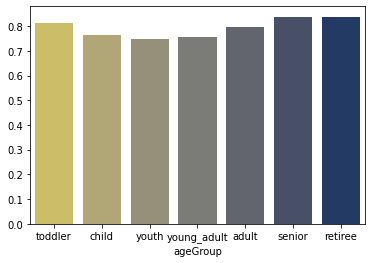

In [867]:
age_order = ['toddler', 'child', 'youth', 'young_adult', 'adult', 'senior', 'retiree']
df_ratios = df[df.noShow == 'No'].groupby(['ageGroup']).size()/df.groupby(['ageGroup']).size()
fig = sns.barplot(x=df_ratios.index, y=df_ratios, palette="cividis_r", order=age_order) 
plt.show()

There are noticeable differences so this should be a useful feature, and the differences are in line with my preliminary assumptions. Since we have the age group, we should now drop the age column. 

In [868]:
df.drop('age', axis=1, inplace=True)

In [869]:
df.head()

,gender,scholarship,hypertension,diabetes,alcoholism,handicap,smsReceived,noShow,scheduledHour,timeToAppointment,appointmentDayName,ageGroup
0,F,0,1,0,0,0,0,No,18,0,Friday,senior
1,M,0,0,0,0,0,0,No,16,0,Friday,senior
2,F,0,0,0,0,0,0,No,16,0,Friday,senior
3,F,0,0,0,0,0,0,No,17,0,Friday,child
4,F,0,1,1,0,0,0,No,16,0,Friday,senior


We should change `noShow` to have a value of 0 or 1. 

In [870]:
def noshowclass(noshow): 
    if noshow == 'Yes': 
        return 1
    else: 
        return 0
    
df["noShow"] = df.noShow.apply(noshowclass)

Depending on the model, we could be using [one-hot-encode](https://en.wikipedia.org/wiki/One-hot) for categorical variables, which are: 
- gender
- scheduledHour
- appointmentDayName
- ageGroup

However, I will proceed with a decision-tree-type models which have proven efficiency in tasks similar to the considered one. Because of this, I will not be one-hot-encoding variables as the consensus is that this is not beneficial for decision tree-based models (here is an [interesting discussion](https://www.kaggle.com/c/zillow-prize-1/discussion/38793)). Scaling is also not required for decision-tree-based methods. 

In [871]:
df.sample(5)

,gender,scholarship,hypertension,diabetes,alcoholism,handicap,smsReceived,noShow,scheduledHour,timeToAppointment,appointmentDayName,ageGroup
355,M,0,1,1,0,0,1,0,9,39,Friday,senior
22786,F,0,0,0,0,0,0,0,7,0,Thursday,adult
48617,M,0,1,0,0,0,0,0,8,3,Thursday,retiree
101158,F,0,1,1,0,0,0,0,16,0,Thursday,retiree
8636,M,0,0,0,0,0,0,0,15,0,Tuesday,adult


### Dependent / independent feature split and modeling

#### Decision trees

In [872]:
# Need to use labelencoder first to transform features (strings) to numbers  
from sklearn.preprocessing import LabelEncoder

for colname in ['gender', 'appointmentDayName', 'ageGroup']: 
    le = LabelEncoder()
    df[colname] = le.fit_transform(df[colname])  
    
X = df.drop(['noShow'], axis=1)
y = df['noShow']

In [873]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

We will use a `RandomForestClassifier`, later on we could iterate using `XGBoost` or `LightGBM`. 

In [874]:
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)

y_pred=rf_clf.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))

Accuracy: 0.7647715276730508
Precision: 0.3538077403245943
Recall: 0.21378998189499096


Let's also look at the confusion matrix: 

In [875]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Function to plot the confusion matrix 
    Used https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html    
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
        cm = np.round(cm, 3)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
Normalized confusion matrix


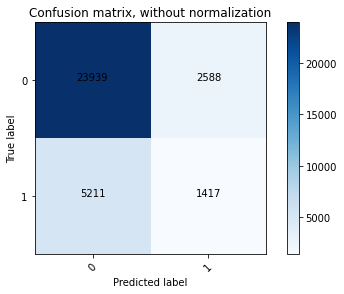

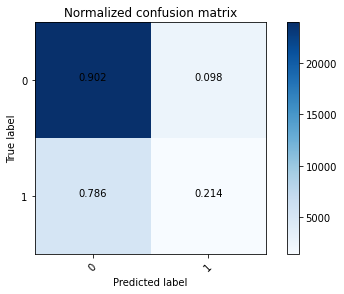

In [876]:
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Let's try DecisionTreeClassifier: 

Accuracy: 0.7537324687075856
Precision: 0.33497960060124543
Recall: 0.23536511768255883
Normalized confusion matrix


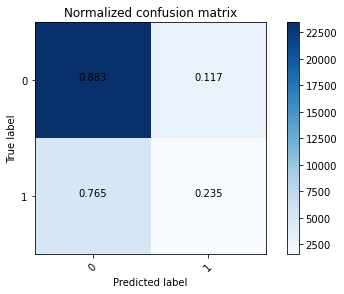

In [877]:
clf_tree = tree.DecisionTreeClassifier()

clf_tree.fit(X_train, y_train)

y_pred=clf_tree.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))

cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Let's also try to use oversampling to handle the class imbalance and see if this helps: 

In [878]:
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state = 2) 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel()) 
  
print('After OverSampling, the shape of train_X is: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y is: {} \n'.format(y_train_res.shape)) 
  
print("After OverSampling, counts of label '1' is: {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '0' is: {}".format(sum(y_train_res == 0))) 

After OverSampling, the shape of train_X is: (123356, 11)
After OverSampling, the shape of train_y is: (123356,) 

After OverSampling, counts of label '1' is: 61678
After OverSampling, counts of label '0' is: 61678


DecisionTreeClassifier after resampling: 

Accuracy: 0.684089880862615
Precision: 0.30175257731958766
Recall: 0.4416113458056729
Normalized confusion matrix


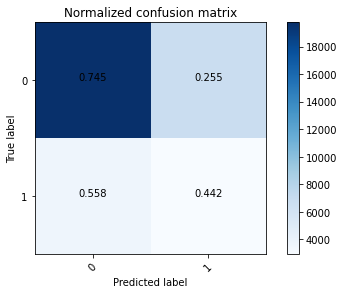

In [879]:
clf_tree = tree.DecisionTreeClassifier()

clf_tree.fit(X_train_res, y_train_res)

y_pred=clf_tree.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))

cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Even though the accuracy is lower, precision and recall have improved. 

In [880]:
print("Feature Importance:\n")
for name, importance in zip(X.columns, np.sort(clf_tree.feature_importances_)[::-1]):
    print("{}: {:.2f}".format(name, importance))

Feature Importance:

gender: 0.45
scholarship: 0.23
hypertension: 0.11
diabetes: 0.10
alcoholism: 0.02
handicap: 0.02
smsReceived: 0.02
scheduledHour: 0.02
timeToAppointment: 0.01
appointmentDayName: 0.01
ageGroup: 0.01


Let's check the ROC curve as well: 

In [881]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

def plot_roc(model, xtest, ytest): 
    
    ns_probs = [0 for _ in range(len(ytest))]    
    lr_probs = model.predict_proba(xtest) 
    lr_probs = lr_probs[:, 1] 
    
    ns_auc = roc_auc_score(ytest, ns_probs)
    lr_auc = roc_auc_score(ytest, lr_probs) 
    
    # Calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # Plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill', color="black")
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Classifier', color="blue")
    # Axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # Show the legend
    pyplot.legend()
    # Show the plot
    pyplot.show()

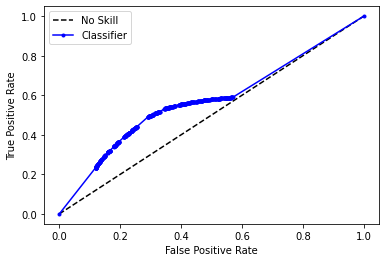

In [882]:
plot_roc(clf_tree, X_test, y_test)

This doesn't look very well. We should also remember that the goal is to predict `noShow`, which this model is not great at. 

#### Logistic regression

Let's also see how the logistic regression performs. To proceed, we should normalise data for performance and also for interpretability. We will also use SMOTE here.   

In [883]:
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(StandardScaler().fit_transform(X), y, 
                                                    test_size=0.3, random_state=0)

In [884]:
sm = SMOTE(random_state = 2) 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel()) 

Accuracy: 0.6600512743175991
Precision: 0.30732840899659725
Recall: 0.5586904043452021

Normalized confusion matrix


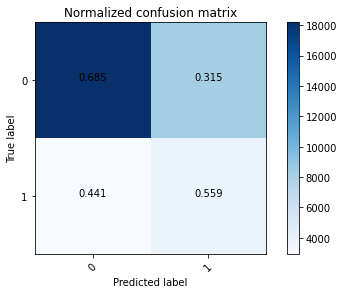

In [885]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=10000, penalty='l2')
logreg.fit(X_train_res, y_train_res)
y_pred = logreg.predict(X_test)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))

print()

cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

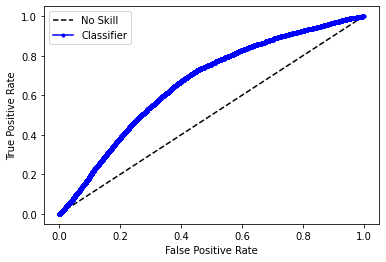

In [886]:
plot_roc(logreg, X_test, y_test)

This looks much better. We can also interpret the coefficients: 

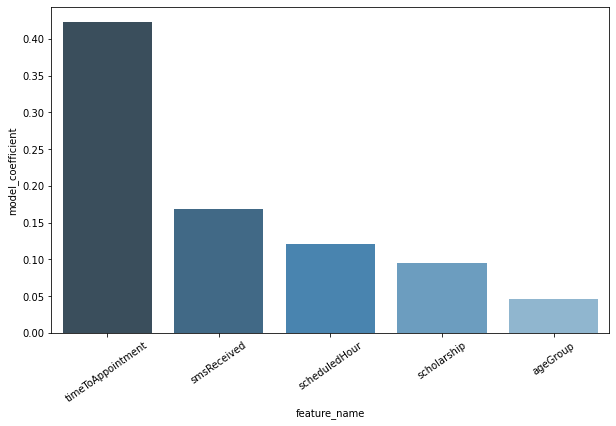

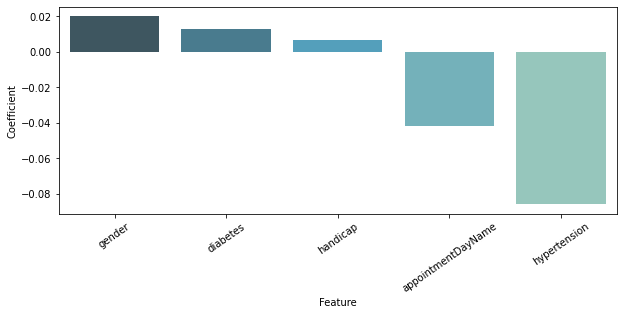

In [888]:
feature_cols = df.columns.tolist()
feature_cols.remove('noShow')

# Top 5 and bottom 5 coefficients
logReg_coeff = pd.DataFrame({'feature_name': feature_cols, 
                             'model_coefficient': logreg.coef_.transpose().flatten()})
logReg_coeff = logReg_coeff.sort_values('model_coefficient',ascending=False)
logReg_coeff_top = logReg_coeff.head(5)
logReg_coeff_bottom = logReg_coeff.tail(5)

# Plot top 5 coefficients
plt.figure().set_size_inches(10, 6)
fg3 = sns.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_top, palette="Blues_d")
fg3.set_xticklabels(rotation=35, labels=logReg_coeff_top.feature_name)

# Plot bottom 5 coefficients
plt.figure().set_size_inches(10,6)
fg4 = sns.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_bottom, palette="GnBu_d")
fg4.set_xticklabels(rotation=35, labels=logReg_coeff_bottom.feature_name)
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.subplots_adjust(bottom=0.4)